# Análise dos Microdados do Enem

**Contexto da análise do trabalho:** Análise do impacto da COVID-19 nos números da região Centro-oeste referente aos anos de 2018 a 2022.

**Onde encontrar os dados:** [Dados do Enem - INEP](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem)

**Abaixo se encontra a importação das bibliotecas e carregamento dos dados**

Anteriormente, a limpeza dos dados foi realizada, resultando no arquivo 'ENEM_CO_TRATADO.parquet'.
Este arquivo será o foco de nossas análises.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import scipy.stats as stats
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats

dados_tratados = pd.read_parquet('ENEM_CO_TRATADO.parquet')

**Tabelas "de-para"** são estruturas fundamentais em análise de dados e processamento de informações. Elas permitem a criação de associações entre valores originais e valores correspondentes, simplificando a interpretação e manipulação de dados complexos. Com funções específicas para cada tabela, como idade, cor/raça, nacionalidade, situação de conclusão, ano de conclusão e status de redação, podemos modularizar a criação dessas tabelas, tornando o código mais organizado e fácil de manter. Assim, o arquivo central pode importar essas funções prontas para uso, economizando tempo e facilitando a manipulação de dados em projetos analíticos. Essas tabelas são uma ferramenta valiosa para simplificar dados complexos e obter insights significativos de forma eficiente.

In [18]:
from tabelas_de_para import (
    criar_tabela_de_para_idades,
    criar_tabela_de_para_cor_raca,
    criar_tabela_de_para_nacionalidade,
    criar_tabela_de_para_situacao_conclusao,
    criar_tabela_de_para_ano_conclusao,
    criar_tabela_de_para_status_redacao
)

In [19]:
dp_idades = criar_tabela_de_para_idades()
dp_raca = criar_tabela_de_para_cor_raca()
dp_nacionalidade = criar_tabela_de_para_nacionalidade()
dp_conclusao = criar_tabela_de_para_situacao_conclusao()
dp_ano_conclusao = criar_tabela_de_para_ano_conclusao()
dp_redacao = criar_tabela_de_para_status_redacao()

# Análise Exploratória das Variáveis
**Visualizações de algumas variáveis para possíveis insights.**

A função **mostrar_estatisticas()** recebe um DataFrame de dados como entrada e exibe estatísticas descritivas, incluindo média, desvio padrão, mínimo, 25º percentil, mediana, 75º percentil e máximo, para as colunas numéricas específicas do DataFrame. Ela formata a exibição dos números como floats com 2 casas decimais.


In [20]:
from estatisticas import mostrar_estatisticas
mostrar_estatisticas(dados_tratados)

,NU_NOTA_REDACAO,NU_NOTA_GERAL,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
count,1760255.00,1760255.00,1760255.00,1760255.00,1760255.00,1760255.00
mean,350.04,301.34,286.40,329.25,323.25,307.45
std,315.56,261.81,249.28,266.09,258.19,273.35
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00
50%,400.00,439.45,407.90,445.90,457.30,410.80
75%,600.00,522.15,497.10,556.20,541.50,530.00
max,1000.00,848.77,869.60,862.60,810.20,996.10


Este código calcula o tamanho necessário de uma amostra representativa de uma população significativa com 1.760.255 entradas. A abordagem adotada considera uma margem de erro de 2% e um nível de confiança de 99%, resultando em um valor crítico de Z de 2,575. Como a distribuição da população é desconhecida, foi escolhido um valor conservador de 0,5 como proporção.

A fórmula utilizada para calcular o tamanho da amostra é apresentada abaixo:

$$
n = \frac{{Z^2 \cdot P \cdot (1 - P)}}{{E^2}}
$$

Nesta equação, "n" representa o tamanho da amostra necessário, "Z" é o valor crítico de 2,575, "P" é a proporção conservadora de 0,5 e "E" é a margem de erro desejada de 2%. Essa abordagem visa obter uma amostra representativa da população, permitindo análises estatísticas mais precisas.


In [21]:
valor_critico_z = 2.575
proporcao_conservadora = 0.5
margem_de_erro = 0.02

tamanho_amostra = (((valor_critico_z**2) * proporcao_conservadora *
                   (1 - proporcao_conservadora)) / (margem_de_erro**2)) // 1 + 1

print("Tamanho da amostra necessário:", tamanho_amostra)


Tamanho da amostra necessário: 4145.0


Definimos o tamanho da amostra desejada como "tamanho_amostra" e usamos uma semente (seed) de 123 para garantir a reprodutibilidade dos resultados.

A amostra é criada a partir dos "dados_tratados" usando a função "sample()" do pandas, e o resultado é armazenado na variável "amostra_aleatoria".


In [22]:
amostra_aleatoria = dados_tratados.sample(n=int(tamanho_amostra), random_state=123)


## Análise de Inscritos
A análise de inscritos tem como objetivo investigar a relação entre o número de inscritos e a presença no ENEM ao longo dos anos, no período de 2018 a 2022.




#### Como a faixa etária dos inscritos mudou ao longo da pandemia?
Neste código, realizamos uma análise estatística que explora como a quantidade de alunos está distribuída ao longo dos anos em diferentes faixas etárias, incluindo o impacto da pandemia da COVID-19 no período de 2018 a 2022. O heatmap gerado visualiza essa distribuição, permitindo a identificação de tendências e variações na faixa etária dos alunos inscritos ao longo do tempo.

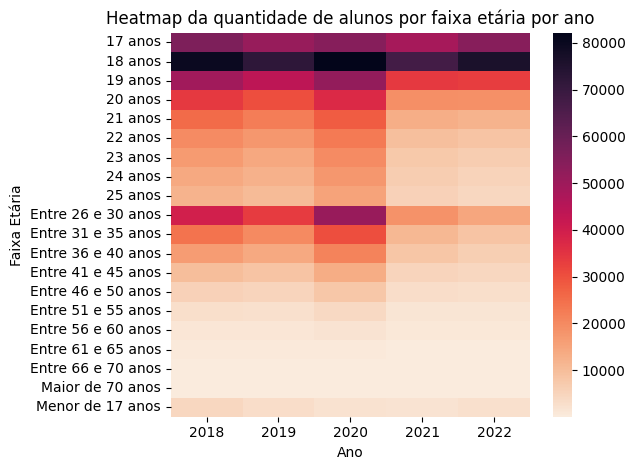

In [23]:
faixa_etaria_ano = dados_tratados.merge(
    dp_idades, left_on='TP_FAIXA_ETARIA', right_index=True, how='left')

faixa_etaria_ano = faixa_etaria_ano.groupby(
    ['faixa_etaria', 'NU_ANO']).size().unstack()

cmap = sns.cm.rocket_r

sns.heatmap(faixa_etaria_ano, cmap=cmap)
plt.title('Heatmap da quantidade de alunos por faixa etária por ano')
plt.xlabel('Ano')
plt.ylabel('Faixa Etária')
plt.tight_layout()
plt.show()



1. **Concentração de Participantes:**
   - A concentração de participantes em uma faixa etária é calculada como a proporção de participantes nessa faixa em relação ao total de participantes.
   
   - Fórmula: `concentracao = participantes_na_faixa / total_participantes`
   - Se `concentracao` for maior que 0,5 (50%), há uma concentração significativa de participantes na faixa etária.

2. **Teste de Normalidade:**
   - O teste de normalidade D'Agostino e Pearson é usado para verificar se as médias de idade dentro da faixa etária seguem uma distribuição normal.
   - O teste gera um p-valor.
   - Se `p_value_normality` for menor que o nível de significância (`nivel_significancia`), as médias de idade não estão normalizadas; caso contrário, estão normalizadas.



In [24]:
def analisar_tabela_idades(dp_idades, faixa_etaria_min, faixa_etaria_max, nivel_significancia=0.05):

    # Filtra as faixas etárias de interesse
    dados_filtrados = dp_idades.loc[
        (dp_idades.index >= faixa_etaria_min) & (
            dp_idades.index <= faixa_etaria_max)
    ]

    # Verifica se a concentração de participantes está entre as faixas etárias desejadas
    total_participantes = dp_idades['media_idade'].sum()
    participantes_na_faixa = dados_filtrados['media_idade'].sum()

    if participantes_na_faixa / total_participantes > 0.5:
        concentracao_message = f"Há uma concentração significativa de participantes entre {faixa_etaria_min} e {faixa_etaria_max} anos.\n"
    else:
        concentracao_message = "Não há uma concentração significativa de participantes nessa faixa etária.\n"

    # Realiza o teste de normalidade nas médias de idade se houver amostras suficientes
    if len(dados_filtrados) >= 8:
        _, p_value_normality = stats.normaltest(dados_filtrados['media_idade'])

        if p_value_normality < nivel_significancia:
            normalidade_message = "As médias de idade não estão normalizadas."
        else:
            normalidade_message = "As médias de idade estão normalizadas."
    else:
        normalidade_message = "Não há amostras suficientes para realizar o teste de normalidade."

    # Retorna a mensagem de análise com quebras de linha
    return f"{concentracao_message}{normalidade_message}"

print(analisar_tabela_idades(dp_idades, 17, 19))

Não há uma concentração significativa de participantes nessa faixa etária.
Não há amostras suficientes para realizar o teste de normalidade.


**Análise do Resultado**


1. **Concentração de Participantes**: O código verifica se há uma concentração significativa de participantes na faixa etária de 17 a 19 anos, com base nas médias de idade em relação ao total de participantes. O resultado obtido é que "Não há uma concentração significativa de participantes nessa faixa etária." Isso significa que, estatisticamente, a proporção de participantes entre 17 e 19 anos em relação ao total não é considerada significativamente maior do que 50%.

2. **Teste de Normalidade**: O código realiza um teste de normalidade (Anderson-Darling) nas médias de idade das faixas etárias de 17 a 19 anos. No entanto, para que o teste seja válido, é necessário ter um número mínimo de amostras disponíveis. O resultado obtido é que "Não há amostras suficientes para realizar o teste de normalidade." Isso significa que a quantidade de dados na faixa etária específica é tão pequena que não é possível concluir estatisticamente se a distribuição das idades nessa faixa etária segue uma distribuição normal.

Esses resultados podem não coincidir diretamente com a observação visual de um gráfico, uma vez que a análise estatística se baseia em critérios estatísticos rígidos e pode não refletir a concentração visualmente percebida de participantes nessa faixa etária.

#### Qual o perfil escolar dos estudantes inscritos no ENEM nos últimos 5 anos?

 o código fornece uma representação visual da distribuição da quantidade de alunos inscritos no ENEM nos últimos 5 anos, segmentada por tipo de escola. Isso permite a análise estatística das tendências na escolha de escolas pelos inscritos ao longo desse período, destacando diferenças e mudanças ao longo do tempo.

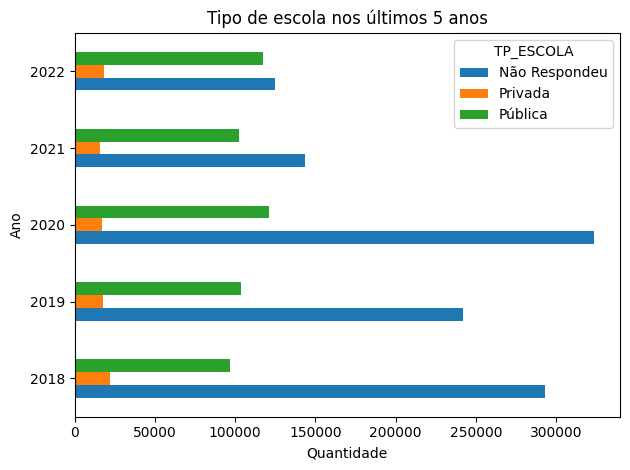

In [25]:
# Filtrar os dados para incluir apenas os últimos 5 anos
dados_ultimos_5_anos = dados_tratados[dados_tratados['NU_ANO'] >= dados_tratados['NU_ANO'].max() - 4]

# Plotar tipo de escola x anos (barras duplas)
tipo_escola = dados_ultimos_5_anos[['NU_ANO', 'TP_ESCOLA']].value_counts()
tipo_escola = tipo_escola.unstack()
tipo_escola.plot.barh()

# Printando
plt.title('Tipo de escola nos últimos 5 anos')
plt.xlabel('Quantidade')
plt.ylabel('Ano')
plt.tight_layout()
plt.show()


In [26]:
# Tabela de contingência para os dados
tabela_contingencia = pd.crosstab(dados_ultimos_5_anos['NU_ANO'], dados_ultimos_5_anos['TP_ESCOLA'])

# Realizar o teste qui-quadrado
qui_quadrado, valor_p, _, _ = stats.chi2_contingency(tabela_contingencia)

# Nível de significância (geralmente 0.05)
alfa = 0.05

# Verificar se rejeitamos ou não a hipótese nula
if valor_p < alfa:
    print("Rejeitamos a hipótese nula:\nHá uma mudança significativa na distribuição dos tipos de escola nos últimos 5 anos.")
else:
    print("Não rejeitamos a hipótese nula:\nNão há evidências suficientes para concluir que houve uma mudança significativa na distribuição dos tipos de escola nos últimos 5 anos.")

Rejeitamos a hipótese nula:
Há uma mudança significativa na distribuição dos tipos de escola nos últimos 5 anos.


#### Como a quantidade de ausentes mudou ao longo do tempo?
O código analisa dados de presença de alunos ao longo dos anos. Ele seleciona as colunas de "ano" e "tipo de presença" de um conjunto de dados tratados. Depois, filtra os registros em que a presença é "falsa" (ausente) e agrupa esses dados por ano, contando a quantidade de ausências em cada ano. Essa análise estatística não inclui um teste formal de hipótese, mas fornece uma visualização simples e descritiva da quantidade de alunos ausentes ao longo do tempo. É uma análise exploratória que permite observar as tendências gerais na presença dos alunos nos exames ENEM ao longo dos anos.

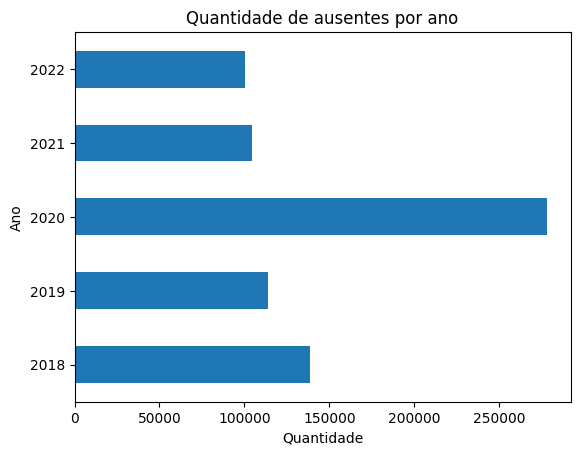

In [27]:
# Selecionar os anos e o status de presença
ausentes = dados_tratados[['NU_ANO', 'TP_PRESENCA']]

# Filtrar os dados para incluir apenas os ausentes (TP_PRESENCA = False)
ausentes = ausentes[ausentes['TP_PRESENCA'] == False]

# Agrupar por ano e contar a quantidade de ausentes em cada ano
ausentes_por_ano = ausentes.groupby('NU_ANO').count()

# Plotar um gráfico de barras horizontal
ausentes_por_ano.plot.barh(legend=False)

# Configurar títulos e rótulos
plt.title('Quantidade de ausentes por ano')
plt.xlabel('Quantidade')
plt.ylabel('Ano')

# Exibir o gráfico
plt.show()


#### Como a pandemia afetou a taxa de ausência nos exames do ENEM quanto o número total de inscritos no exame?
O código analisa estatisticamente a relação entre o número de inscritos totais e o número de presentes nos exames do ENEM ao longo dos anos, permitindo a observação das variações na taxa de ausência e, consequentemente, avaliando o impacto da pandemia nessa taxa.

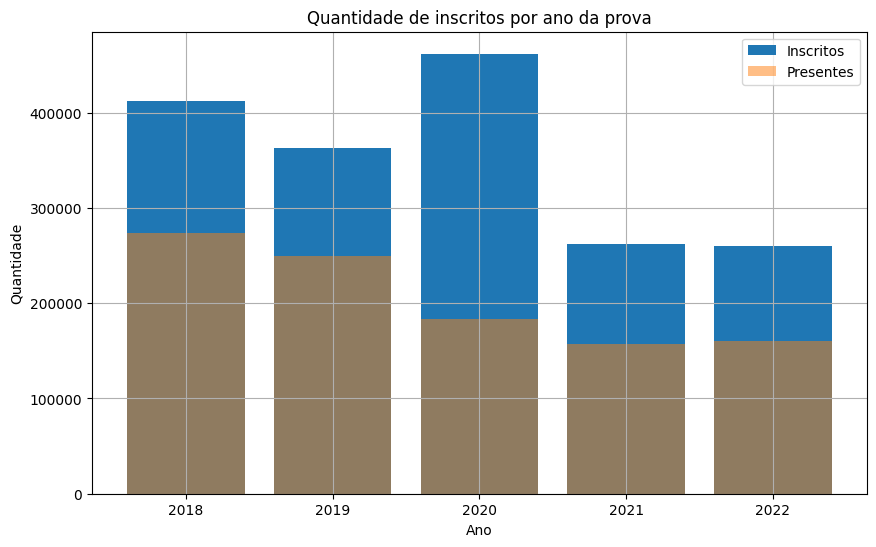

In [28]:
# Contagem de inscritos por ano
inscritos_por_ano = dados_tratados['NU_ANO'].value_counts().sort_index()

# Contagem de presentes por ano
presentes_por_ano = dados_tratados[dados_tratados['TP_PRESENCA'] == True]['NU_ANO'].value_counts().sort_index()

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(inscritos_por_ano.index, inscritos_por_ano.values, label='Inscritos')
plt.bar(presentes_por_ano.index, presentes_por_ano.values, label='Presentes', alpha=0.5)  # Barras transparentes para presentes
plt.title('Quantidade de inscritos por ano da prova')
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.grid(True)

# Adicionar a legenda
plt.legend()

plt.show()

No gráfico, podemos observar que o ano de 2020, marcado pelo início da pandemia, registrou o maior número de inscritos em relação ao período analisado. No entanto, também apresentou a menor taxa de conversão desses inscritos em participantes na prova, possivelmente devido às preocupações com a pandemia e outros fatores que impactaram a presença dos candidatos no local do exame. Isso indica uma análise estatística interessante sobre o impacto da pandemia na participação dos alunos no ENEM.